# Comparison of CNN and Dense version of IG
* ig dense and ig cnn runs on same data, CNN gets neighboors
* comparison between images
* phantom setup

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorboard.plugins.hparams import api as hp
from src.models.ig_cnn import get_cnn_dataset, ig_cnn_model
from src.tftools.callbacks.t2_callbacks import ImageNirCallback, InformationGainCallback, ImagesCallback
dataset_params = {
    'image_path' : '../data/raw/still_life/sample_22.mat',
    'input_size' : 3 ,
    'samples_overlay' : False
}
hparams = {
    'model_def'  : 'C-25-3-sigmoid-valid,C-25-1-sigmoid-same',
    'log_name' : 'comparison',
    'log_root' : '../logs/'
}

In [2]:
# TODO: Make fixed validation training set

inputs_cnn, outputs_cnn, cnn_target, cnn_input = get_cnn_dataset(**dataset_params)
print(f'CNN:\tInput shape {inputs_cnn.shape},\n\tOutput shape{outputs_cnn.shape}')

# Get middle
inputs_dense = inputs_cnn[:,1,1,:]
outputs_dense = outputs_cnn[:,0,0,:]
# Pad the output
dense_target = cnn_target
dense_input = cnn_input[1:-1, 1:-1]
print(f'DENSE:\tInput shape {inputs_dense.shape},\n\tOutput shape{outputs_dense.shape}')

CNN:	Input shape (40000, 3, 3, 16),
	Output shape(40000, 1, 1, 1)
DENSE:	Input shape (40000, 16),
	Output shape(40000, 1)


In [3]:
model_cnn = ig_cnn_model(hparams['model_def'])
model_cnn.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mean_squared_error'])

_log_dir = os.path.join(hparams['log_root'],
                        hparams['log_name'],
                        'cnn')

model_cnn_callbacks = [tf.keras.callbacks.TensorBoard(log_dir=_log_dir),
             InformationGainCallback(input_image=cnn_input,
                                     target_image=cnn_target,
                                     logdir=_log_dir),
             ImagesCallback(input_image=cnn_input,
                            target_image=cnn_target,
                            logdir=_log_dir),
             ImageNirCallback(input_image=cnn_input,
                              target_image=cnn_target,
                              logdir=_log_dir),
             hp.KerasCallback(_log_dir,{**hparams, **dataset_params}),
             # NOTE: This callback has to be last
             tf.keras.callbacks.EarlyStopping(patience=6, min_delta=10 ** -5),
 ]

In [4]:
def get_ig_dense(layers=[25,25],
                 input_shape=(16),
                 output_shape=(1)):
    input_layer = tf.keras.layers.Input(shape=input_shape,
                                        dtype=tf.float32,
                                        name='InputLayer')
    layer = input_layer
    if layers is None:
        layers = [25, 25]
    for layer_idx in range(len(layers)):
        layer = tf.keras.layers.Dense(layers[layer_idx],
                                      activation='sigmoid',
                                      name='Dense' + str(layer_idx))(layer)

    flat_layer = tf.keras.layers.Flatten()(layer)
    output_layer = tf.keras.layers.Dense(output_shape,
                                         activation='sigmoid',
                                         name='Output')(flat_layer)

    model = tf.keras.models.Model(inputs=input_layer,
                                  outputs=output_layer)

    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['mean_squared_error']
                  )
    return model

In [5]:
model_dense = get_ig_dense()
model_dense.summary()

_log_dir = os.path.join(hparams['log_root'],
                        hparams['log_name'],
                        'dense')

model_dense_callbacks = [tf.keras.callbacks.TensorBoard(log_dir=_log_dir),
             InformationGainCallback(input_image=dense_input,
                                     target_image=dense_target,
                                     logdir=_log_dir),
             ImagesCallback(input_image=dense_input,
                            target_image=dense_target,
                            logdir=_log_dir),
             ImageNirCallback(input_image=dense_input,
                              target_image=dense_target,
                              logdir=_log_dir),
             hp.KerasCallback(_log_dir,{**hparams, **dataset_params}),
             # NOTE: This callback has to be last
             tf.keras.callbacks.EarlyStopping(patience=6, min_delta=10 ** -5),
 ]

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
InputLayer (InputLayer)      [(None, 16)]              0         
_________________________________________________________________
Dense0 (Dense)               (None, 25)                425       
_________________________________________________________________
Dense1 (Dense)               (None, 25)                650       
_________________________________________________________________
flatten (Flatten)            (None, 25)                0         
_________________________________________________________________
Output (Dense)               (None, 1)                 26        
Total params: 1,101
Trainable params: 1,101
Non-trainable params: 0
_________________________________________________________________


In [6]:
history_cnn = model_cnn.fit(inputs_cnn,
                            outputs_cnn,
                            epochs=100,
                            validation_split=0.2,
                            verbose=1,
                            callbacks=model_cnn_callbacks
                        )

Epoch 1/100
1000/1000 [==============================] - 2s 2ms/step - loss: 0.0072 - mean_squared_error: 0.0072 - val_loss: 0.0038 - val_mean_squared_error: 0.0038

In [7]:
history_dense = model_dense.fit(inputs_dense,
                          outputs_dense,
                          epochs=100,
                          validation_split=0.2,
                          verbose=1,
                          callbacks=model_dense_callbacks
                        )

Epoch 1/100
1000/1000 [==============================] - 1s 1ms/step - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0048 - val_mean_squared_error: 0.0048

## Load data
middles for Dense and squares for CNN
aware of leaking data

## Create model
same loss, the outputs are the same

## Train
* independently and gets the last image as reference, merge logs

## Callbacks for models
Log
* information gain (read the paper)
* resulting image

## Design the phantom experiment
* Think it over

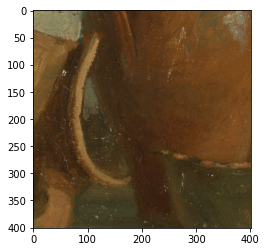

In [17]:
import matplotlib.pyplot as plt
from src.visualization.color_transformation import wavelength2rgb
plt.imshow(wavelength2rgb(cnn_input))
plt.imsave('visible.png', wavelength2rgb(cnn_input))


In [15]:
import os
os.getcwd()


'C:\\Users\\Tomas Karella\\Desktop\\igre\\notebooks'